<a href="https://colab.research.google.com/github/jcvasquezbetancur/DS-colab/blob/master/Auto_encoder_coursera.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dimensionality Reduction using an Autoencoder in Python 

## Project Outline
[**Task 1**](#task1): Package Importing and Introduction to Project

[**Task 2**](#task2): Dataset Creation and Preprocessing

[**Task 3**](#task3): Create a Baseline Model with PCA

[**Task 4**](#task4): Autoencoder Introduction and Training

[**Task 5**](#task5): Reducing Dimensionality with AE

## Appendix
* tried to translate to pytorch with Hummingbird and compare  timing but that SKL-model is not yet supported. Will let it incomplete while MLPRegressor gets supported soon.

<a id='task1'></a>
# Task 1: Importing and Introduction

In [1]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np

In [2]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA

from sklearn.metrics import mean_squared_error, silhouette_score

In [3]:
cols = ['#1FC17B', '#78FECF', '#555B6E', '#CC998D', '#429EA6',
        '#153B50', '#8367C7', '#EE6352', '#C287E8', '#F0A6CA', 
        '#521945', '#361F27', '#828489', '#9AD2CB', '#EBD494', 
        '#53599A', '#80DED9', '#EF2D56', '#446DF6', '#AF929D']

<a id='task2'></a>
# Task 2: Dataset Creation and Preprocessing

In [4]:
X, y = make_blobs(n_features=50, centers=20, n_samples=20000, cluster_std=0.2, 
                  random_state=17, center_box=[-1, 1])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=17)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

<a id='task3'></a>
# Task 3: Baseline Model

Text(0.5, 1.0, 'PCA Results')

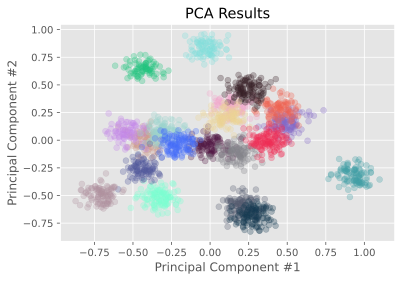

In [6]:
pca = PCA(n_components=2)
pca.fit(X_train)

res_pca = pca.transform(X_test)

unique_labels = np.unique(y_test)

for index, unique_label in enumerate(unique_labels):
    X_data = res_pca[y_test==unique_label]
    plt.scatter(X_data[:,0], X_data[:,1], alpha=0.3, c=cols[index])
    
plt.xlabel('Principal Component #1')
plt.ylabel('Principal Component #2')
plt.title('PCA Results')

<a id='task4'></a>
# Task 4: Autoencoder Theory and Training

In [7]:
%%time
autoencoder = MLPRegressor(alpha=1e-15, 
                           hidden_layer_sizes=(50, 100, 50, 2, 50, 100, 50), 
                           random_state=1, max_iter=40000)

autoencoder.fit(X_train, X_train)

CPU times: user 24 s, sys: 12 s, total: 36 s
Wall time: 18.4 s


<a id='task5'></a>
# Task 5: Reducing Dimensionality with Encoder

In [8]:
W = autoencoder.coefs_
biases = autoencoder.intercepts_

In [9]:
encoder_weights = W[0:4]
encoder_biases = biases[0:4]

In [10]:
def encoder(encoder_weights, encoder_biases, data):
    res_ae = data
    for index, (w, b) in enumerate(zip(encoder_weights, encoder_biases)):
        if index+1 == len(encoder_weights):
            res_ae = res_ae@w+b 
        else:
            res_ae = np.maximum(0, res_ae@w+b)
    return res_ae
            
res_ae = encoder(encoder_weights, encoder_biases, X_test)

Text(0.5, 1.0, 'Autoencoder Results')

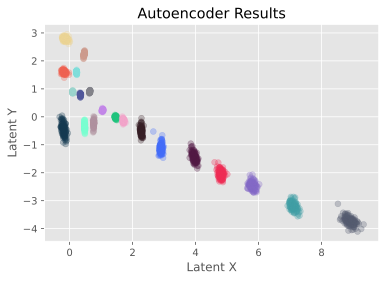

In [11]:
unique_labels = np.unique(y_test)

for index, unique_label in enumerate(unique_labels):
    latent_space = res_ae[y_test==unique_label]
    plt.scatter(latent_space[:,0], latent_space[:,1], alpha=0.3, c=cols[index])

plt.xlabel('Latent X')
plt.ylabel('Latent Y')
plt.title('Autoencoder Results')

In [12]:
silhouette_score(X_train, y_train)

0.6109772034818249

In [13]:
silhouette_score(res_pca, y_test)

0.36786978228998823

In [14]:
silhouette_score(res_ae, y_test)

0.8074659601928073

###total loss

In [15]:
x_new = encoder(W, biases, X_test)

In [16]:
print(mean_squared_error(X_test,x_new))

0.00474468918082944


## Hummingbird setup

In [17]:
!pip install hummingbird-ml 

In [18]:
from hummingbird.ml import convert

# Use Hummingbird to convert the model to PyTorch
model = convert(autoencoder , 'pytorch')

ONNX runtime not installed. Please check https://github.com/microsoft/onnxruntime#installation for instructions.
ONNX runtime not installed. Please check https://github.com/microsoft/onnxruntime#installation for instructions.


MissingConverter: ignored

In [ ]:
%%timeit
# Run predictions on CPU
model.predict(X)

In [ ]:
%%timeit
# Run predictions on GPU
model.to('cuda')
model.predict(X)